In [1]:
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from math import radians, cos, sin, asin, sqrt, atan2, degrees
from datetime import datetime
from time import mktime
from pyspark.sql.window import Window
import pandas as pd
import os
import numpy as np

## Load Data

In [2]:
file_list = os.listdir('data/gps_20161001')
conf = SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','8g')])
sc = SparkContext("local", "Simple App", conf=conf)
sqlContext = SQLContext(sc)

In [3]:
didi_aggr_3 = sqlContext.read.csv('data/gps_20161001')

In [4]:
didi_aggr_3.show()

+---+---+---+----+--------------------+----+
|_c0|_c1|_c2| _c3|                 _c4| _c5|
+---+---+---+----+--------------------+----+
|  3|  1| 61|-1.0|  14.098737356321838|1740|
|  3|  8| 46| 3.0|  32.392894736842116| 190|
|  3|  7|115|-1.0|  2.8088791583166333|9980|
|  0|  2| 70|-1.0|0.001864319005696...|1931|
|  3|  2|100|-1.0|   5.071760677872687|7258|
|  4|  2|131|-1.0|   8.786022483392951|1957|
|  5|  7| 90| 1.0|   25.44599195710456| 746|
|  5|  0|102| 1.0|  23.210146835443016| 790|
|  8|  7| 50| 3.0|   33.87347598253275| 458|
|  2|  5| 63|-1.0|   8.489747444377631|1663|
|  8|  6| 73| 3.0|   26.73153204172876| 671|
|  3|  2|109|-1.0|   6.627792252964427|6325|
|  3|  0| 98|-1.0|  13.397822779243624|2274|
|  2|  6|  3|-1.0|   6.758796445880455|1238|
|  5|  1|139| 1.0|   27.38999999999999| 350|
|  0|  6| 90| 1.0|  35.156109589041094| 584|
|  8|  7| 76| 3.0|  23.631831007751924| 645|
|  6|  0| 59|-1.0|   7.711387900355872| 281|
|  2|  6|125|-1.0|  2.9004978517722875|5586|
|  0|  4|1

## Convert pyspark dataframe into pandas dataframe

In [5]:
didi_df = didi_aggr_3.toPandas()
didi_aggr_3.schema.names

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5']

In [6]:
didi_df.columns = ['x', 'y', 't', 'direction', 'avg_vel', 'nodes']
didi_df.head()

,x,y,t,direction,avg_vel,nodes
0,3,1,61,-1.0,14.098737356321838,1740
1,3,8,46,3.0,32.392894736842116,190
2,3,7,115,-1.0,2.8088791583166333,9980
3,0,2,70,-1.0,0.0018643190056965302,1931
4,3,2,100,-1.0,5.071760677872687,7258


In [8]:
didi_df.sort_values(["x","y","t","direction"])
didi_df.avg_vel = pd.to_numeric(didi_df.avg_vel)
didi_df.nodes = pd.to_numeric(didi_df.nodes)
didi_df.direction = pd.to_numeric(didi_df.direction)
didi_df.t = pd.to_numeric(didi_df.t)
didi_df.x = pd.to_numeric(didi_df.x)
didi_df.y = pd.to_numeric(didi_df.y)

In [9]:
group_x_y = didi_df.groupby(["x","y","t"])

In [10]:
didi_agg = group_x_y.agg({"direction":"sum", "avg_vel":"mean","nodes":"sum"})
didi_agg.head()

direction    avg_vel  nodes
x y t                             
0 0 0        5.0  29.087397    441
    1        5.0  30.073045   1038
    2        5.0  30.638304   1070
    3        5.0  30.868496   1120
    4        5.0  31.104015   1210

In [11]:
didi_agg = didi_agg.reset_index()

In [12]:
didi_agg.sort_values(["x","y","t"])

,x,y,t,direction,avg_vel,nodes
0,0,0,0,5.0,29.087397,441
1,0,0,1,5.0,30.073045,1038
2,0,0,2,5.0,30.638304,1070
3,0,0,3,5.0,30.868496,1120
4,0,0,4,5.0,31.104015,1210
5,0,0,5,5.0,30.862899,927
6,0,0,6,5.0,32.881424,878
7,0,0,7,5.0,29.333440,409
8,0,0,8,5.0,33.058558,347
9,0,0,9,5.0,33.869005,369


## Choose state threshold

##### 1. Velocity

In [13]:
didi_agg.avg_vel.min()

0.0

In [14]:
didi_agg.avg_vel.max()

92.05714285714285

In [15]:
didi_agg.avg_vel.mean()

30.039004602554975

In [16]:
didi_agg.avg_vel.quantile([0.25,0.5,0.75])

0.25    25.580585
0.50    28.826721
0.75    33.364019
Name: avg_vel, dtype: float64

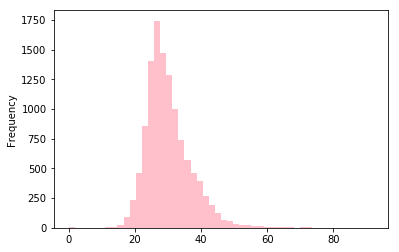

In [186]:
didi_agg.avg_vel.plot.hist(bins = 50, color = "pink")

##### 2. Capacity

In [18]:
didi_agg.nodes.min()

1

In [19]:
didi_agg.nodes.max()

18960

In [20]:
didi_agg.nodes.mean()

2434.6879799810163

In [21]:
didi_agg.nodes.quantile([0.25, 0.5, 0.75])

0.25     502.0
0.50    1757.0
0.75    3619.0
Name: nodes, dtype: float64

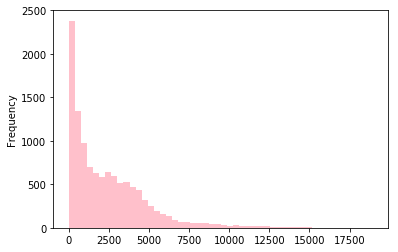

In [183]:
didi_agg.nodes.plot.hist(bins = 50,color = "pink")

In [23]:
# Assume we have 3 states, Busy, Normal, Free

In [24]:
# For velocity, the threshold are: 25, 33
# For nodes, the threshold are: 500, 3600

## Assign State

In [52]:
nodes_low = 500
nodes_high = 3600
vel_low = 25
vel_high = 33

def cal_state(row):
    if row["nodes"] <= nodes_low or row["avg_vel"] >= vel_high:
        return "Free"
    elif nodes_low<row["nodes"] <=nodes_high or vel_low<=row["avg_vel"] <vel_high:
        return "Normal"
    else:
        return "Busy"
didi_agg["State"] = didi_agg.apply(lambda row: cal_state(row), axis = 1)

In [26]:
didi_agg.State.value_counts()

Normal    6151
Free      4293
Busy      1145
Name: State, dtype: int64

## Model (Customized HMM)

In [27]:
def get_State(training_data):
    return list(training_data.State.unique())

In [28]:
def get_observationX(training_data):
    return list(training_data.x.unique())

In [29]:
def get_observationY(training_data):
    return list(training_data.y.unique())

In [30]:
def get_observationT(training_data):
    return list(training_data.t.unique())

In [31]:
State_list = get_State(didi_agg)

In [141]:
def learn_parameters(training_data):  ## train parameters
    tag_set = get_State(training_data)
    observationX = get_observationX(training_data)
    observationY = get_observationY(training_data)
    observationT = get_observationT(training_data)
    
    tag_set_len = len(tag_set)
    
    emission_matrix = dict(left = np.zeros((tag_set_len, tag_set_len)).tolist(),
                           right = np.zeros((tag_set_len, tag_set_len)).tolist(),
                           up = np.zeros((tag_set_len, tag_set_len)).tolist(),
                           bottom = np.zeros((tag_set_len, tag_set_len)).tolist(),
                           middle = np.zeros((tag_set_len, tag_set_len)).tolist())
    
    count_t1 = np.zeros(tag_set_len).tolist()
    count_t0_t1_left = np.zeros((tag_set_len,tag_set_len)).tolist()
    count_t0_t1_right = np.zeros((tag_set_len,tag_set_len)).tolist()
    count_t0_t1_up = np.zeros((tag_set_len,tag_set_len)).tolist()
    count_t0_t1_bottom = np.zeros((tag_set_len,tag_set_len)).tolist()
    count_t0_t1_middle = np.zeros((tag_set_len,tag_set_len)).tolist()
    

    
    for t in observationT:
        for x in observationX:
            for y in observationY:
             
                if t == 0:
                    pass
                else:
                    if training_data[(training_data.x == x) 
                                                         &(training_data.y == y) 
                                                         &(training_data.t == t)].empty:
                        pass
                    else:
                        count_t1[tag_set.index(training_data[(training_data.x == x) 
                                                             &(training_data.y == y) 
                                                             &(training_data.t == t)].iloc[0,-1])]+=1
                        if training_data[(training_data.x == x) 
                                                             &(training_data.y == y) 
                                                             & (training_data.t == t-1)].empty:
                            pass
                        else:
                            count_t0_t1_middle[tag_set.index(training_data[(training_data.x == x) 
                                                                 &(training_data.y == y) 
                                                                 & (training_data.t == t-1)].iloc[0,-1])][
                                               tag_set.index(training_data[(training_data.x == x) 
                                                                 &(training_data.y == y) 
                                                                 & (training_data.t == t)].iloc[0,-1])]+=1
                        if (x-1) in observationX:
                            if training_data[(training_data.x == x) 
                                                                 &(training_data.y == y) 
                                                                 & (training_data.t == t-1)].empty:
                                pass
                            else:
                                count_t0_t1_left[tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t-1)].iloc[0,-1])][
                                                   tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t)].iloc[0,-1])]+=1
                        else:
                            pass
                        
                        if (x+1) in observationX:
                            if training_data[(training_data.x == x) 
                                                                 &(training_data.y == y) 
                                                                 & (training_data.t == t-1)].empty:
                                pass
                            else:

                                count_t0_t1_right[tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t-1)].iloc[0,-1])][
                                                   tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t)].iloc[0,-1])]+=1
                        else:
                            pass
                        
                        if (y+1) in observationY:
                            if training_data[(training_data.x == x) 
                                                                 &(training_data.y == y) 
                                                                 & (training_data.t == t-1)].empty:
                                pass
                            else:

                                count_t0_t1_up[tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t-1)].iloc[0,-1])][
                                                   tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t)].iloc[0,-1])]+=1
                        else:
                            pass
                        
                        if (y-1) in observationY:
                            if training_data[(training_data.x == x) 
                                                                 &(training_data.y == y) 
                                                                 & (training_data.t == t-1)].empty:
                                pass
                            else:
                                count_t0_t1_bottom[tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t-1)].iloc[0,-1])][
                                                   tag_set.index(training_data[(training_data.x == x) 
                                                                     &(training_data.y == y) 
                                                                     & (training_data.t == t)].iloc[0,-1])]+=1
                        else:
                            pass
                    
                    
    for i in range(tag_set_len):
        for j in range(tag_set_len):
            emission_matrix["left"][i][j] = 1.0*(count_t0_t1_left[i][j]+1)/(count_t1[j]+1)
            emission_matrix["right"][i][j] = 1.0*(count_t0_t1_right[i][j]+1)/(count_t1[j]+1)
            emission_matrix["up"][i][j] = 1.0*(count_t0_t1_up[i][j]+1)/(count_t1[j]+1)
            emission_matrix["bottom"][i][j] = 1.0*(count_t0_t1_bottom[i][j]+1)/(count_t1[j]+1)
            emission_matrix["middle"][i][j] = 1.0*(count_t0_t1_middle[i][j]+1)/(count_t1[j]+1)
    
    state_prob_new = [x/len(training_data) for x in state_prob]
    return emission_matrix

In [146]:
def model_decode(training_data, testing_data, emission_matrix, state_prob_new):   ## decode
    tag_set = get_State(training_data)
    observationX = get_observationX(training_data)
    observationY = get_observationY(training_data)
    
    testingX = get_observationX(testing_data)
    testingY = get_observationY(testing_data)
    
    pred_state = []
    
    prob_left = np.ones(len(tag_set))
    prob_right = np.ones(len(tag_set))
    prob_middle = np.ones(len(tag_set))
    prob_up = np.ones(len(tag_set))
    prob_bottom = np.ones(len(tag_set))
    
    for x in testingX:
        for y in testingY:
            if (x in observationX) & (y in observationY):
                if (x-1) in testingX:
                    try:
                        prob_left = emission_matrix["left"][tag_set.index(testing_data[(testing_data.x == x-1) 
                                                                 &(testing_data.y == y) ].iloc[0,-1])]
                    except:
                        pass
                if (x+1) in testingX :
                    try:
                        prob_right = emission_matrix["right"][tag_set.index(testing_data[(testing_data.x == x+1) 
                                                                 &(testing_data.y == y) ].iloc[0,-1])]
                    except:
                        pass
                if (y-1) in testingY:
                    try:
                        prob_bottom = emission_matrix["bottom"][tag_set.index(testing_data[(testing_data.x == x) 
                                                                 &(testing_data.y == y-1) ].iloc[0,-1])]
                    except:
                        pass
                if (y+1) in testingY:
                    try:
                        prob_up = emission_matrix["up"][tag_set.index(testing_data[(testing_data.x == x) 
                                                                 &(testing_data.y == y+1) ].iloc[0,-1])]
                    except:
                        pass
                try:
                    prob_middle = emission_matrix["middle"][tag_set.index(testing_data[(testing_data.x == x) 
                                                                 &(testing_data.y == y) ].iloc[0,-1])]
                except:
                    pass
                
                temp_prob = list(map(lambda x1,x2,x3,x4,x5,x6:x1*x2*x3*x4*x5*x6, prob_left, 
                                     prob_right, prob_middle, prob_up, prob_bottom, state_prob_new))

                pred_state.append(tag_set[np.argmax(temp_prob)])
    
    testing_data["pred_State"] = pred_state
    return testing_data

In [143]:
temp = list(didi_agg.State.value_counts()/len(didi_agg))
state_prob = [temp[1],temp[0],temp[2]]

In [178]:
learned_parameters = learn_parameters(didi_agg)

In [148]:
### Predict t = 1
t_test = 1
test_tk = didi_agg[didi_agg.t == t_test]
pred_data = model_decode(didi_agg, test_tk, learned_parameters,state_prob)

/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Calculating Accuracy

In [158]:
def cal_accuray(test_data, pred_data):
    t = pred_data.iloc[0,2]
    x_pred = get_observationX(pred_data)
    y_pred = get_observationY(pred_data)
    
    test_data = test_data[test_data.t == t+1]
    
    count_all = 0
    count_correct = 0
    
    for x in x_pred:
        for y in y_pred:
            try:
                pred_tag = pred_data[(pred_data.x == x)&(pred_data.y == y) ].iloc[0,-1]
                test_tag = test_data[(test_data.x == x)&(test_data.y == y) ].iloc[0,-1]
                if pred_tag == test_tag:
                    count_correct +=1
                count_all +=1
            except:
                pass
    accuracy = 1.0*count_correct/count_all
    
    return accuracy
            

In [171]:
ts = didi_agg.t.unique()

In [174]:
accuracys = []
for t in ts:
    try:
        test_tk = didi_agg[didi_agg.t == t+1]
        pred_data = model_decode(didi_agg, test_tk, learned_parameters, state_prob)
        accuracys.append(cal_accuray(didi_agg, pred_data))

    except:
        pass

/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [176]:
np.mean(accuracys)

0.7940627172349131

### Output

In [97]:
# t =1 (non-peak period)
# t = 66 (peak period)

ts = [1, 66]

for t in ts:
    test_tk = didi_agg[didi_agg.t == t]
    pred_data = model_decode(didi_agg, test_tk, learned_parameters)[["x", "y", "t", "avg_vel", "nodes", "State", "pred_State"]]
    pred_data["State_tag"] = pred_data.State.map({"Busy": 3, "Normal": 2, "Free": 0})
    pred_data["pred_State_tag"] = pred_data.pred_State.map({"Busy": 3, "Normal": 2, "Free": 0})
    
    name = "t"+str(t) 
    pred_data.to_csv("pred_for_"+name+".csv", index = False)
    

/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
